In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import scipy.stats as st
import simulation_support as simsup
import astropy.visualization as viz

from yaff import common_models as cm
from yaff.fitting import Parameter
from yaff import fitting

%matplotlib widget
import os

plt.style.use(os.getenv("MPL_INTERACTIVE_STYLE"))

In [2]:
total_time = 20 << u.s
time_bin = 0.1 << u.s

time_bins = (
    np.arange(0, (total_time + time_bin).to_value(u.s), time_bin.to_value(u.s)) << u.s
)
time_mids = time_bins[:-1] + np.diff(time_bins) / 2

num_time_bins = time_mids.size

In [19]:
num_injections = 30
injection_rise = 1
injection_fall = 4
# injection_duration = 1 << u.s

rng = np.random.default_rng()
injection_time_indices = rng.integers(0, num_time_bins - 1, size=num_injections)
print(injection_time_indices)

# The spectral index starts linearly going up
indices = simsup.linear_slew(8, 5, num_time_bins)

efluxes = simsup.linear_slew(0.4, 5, num_time_bins)


# The spectral indices and electron fluxes spike
# at the same time: beamlike injection of electrons
for it in injection_time_indices:
    cur_index = indices[it]
    index_delta = rng.uniform(0.1, 0.5)
    indices -= (
        s := simsup.spike(
            time_mids.to_value(u.s),
            time_mids[it].to_value(u.s),
            injection_rise,
            injection_fall,
            index_delta,
        )
    )

    cur_flux = efluxes[it]
    flux_delta = rng.uniform(0.8, 1.8)
    efluxes += simsup.spike(
        time_mids.to_value(u.s),
        time_mids[it].to_value(u.s),
        injection_rise,
        injection_fall,
        flux_delta,
    )

efluxes[efluxes < 0] = 0
# efluxes /= 10

index_cut = 2.1
indices[indices < index_cut] = index_cut

[168  34  41  33  22 136 163 170 190 158  26 147 163 190 118 143 131   5
   3  97 198 166  84  48  67  11  97 148  52 115]


In [20]:
import scipy.signal as sig

critical_freq = 1 / (0.8 << u.s)
sample_rate = 1 / time_bin
order = 5

butterb, buttera = sig.butter(
    N=order,
    Wn=critical_freq.to_value(u.Hz),
    btype="lowpass",
    # Data is already sampled at 0.5s cadence,
    # so we want a digital filter (not analog)
    # see: https://dsp.stackexchange.com/a/40715
    analog=False,
    output="ba",
    fs=sample_rate.to_value(u.Hz),
)

low_idx = sig.filtfilt(butterb, buttera, indices, method="gust")
low_eflux = sig.filtfilt(butterb, buttera, efluxes, method="gust")

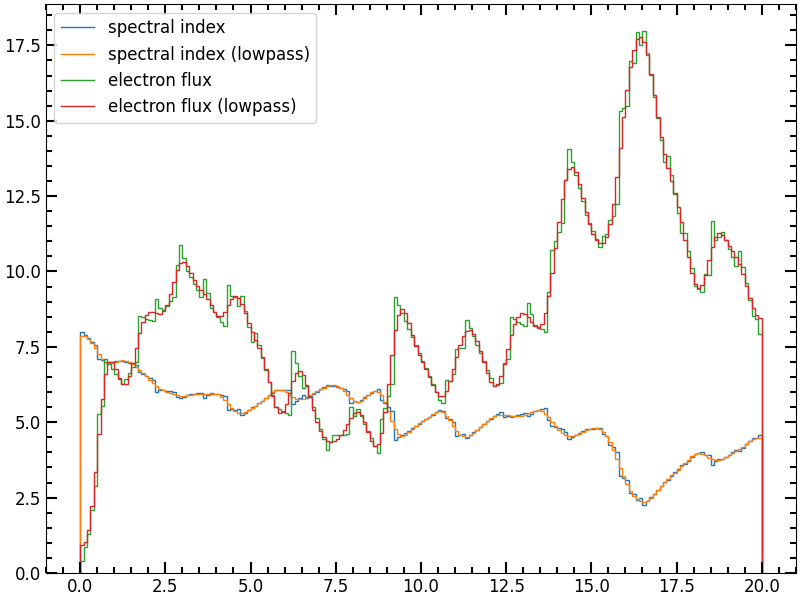

In [22]:
fig, ax = plt.subplots()
ax.stairs(indices, time_bins.value, label="spectral index")
ax.stairs(low_idx, time_bins.value, label="spectral index (lowpass)")
ax.stairs(efluxes, time_bins.value, label="electron flux")
ax.stairs(low_eflux, time_bins.value, label="electron flux (lowpass)")
# lab = 'injection'
# for idx in injection_time_indices:
# ax.axvline(time_mids[idx].value, color='red', alpha=0.6, zorder=-1, label=lab)
# Clear the label so it only shows up once
# lab = None
ax.legend()
plt.show()

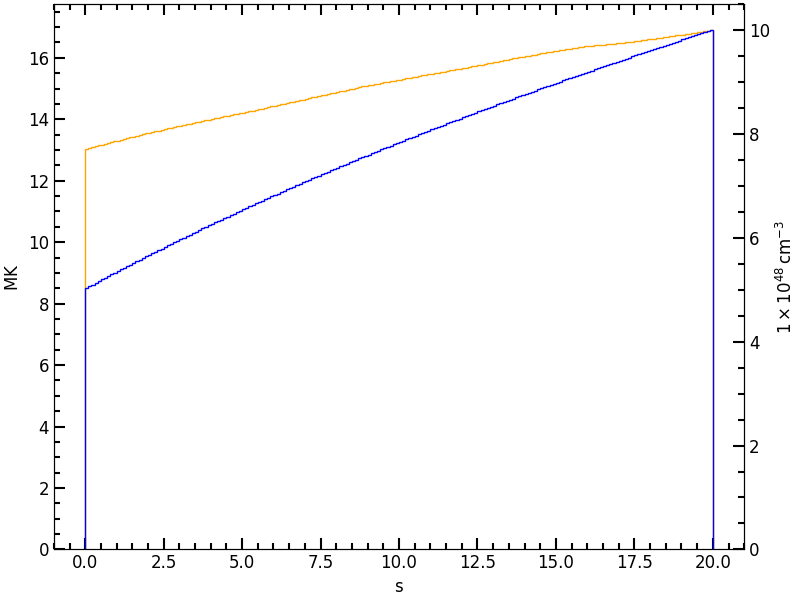

In [23]:
# A poor-man's Neupert effect
temp_start = 13 << u.MK
fudge = 0.3
temp_shape = indices.cumsum()
temp_shape /= temp_shape.max()
temp_shape *= fudge
temp_shape += 1
temps = temp_shape * temp_start


# The emission measure is the cumulative effect of
# heating (??), following ideal gas law
em_start, em_end = (5, 8) << (1e48 * u.cm**-3)
em_shape = (1 / temp_shape**2).cumsum()
em_shape /= em_shape.max()
ems = (1 + em_shape) * em_start


fig, ax = plt.subplots()
with viz.quantity_support():
    ax.stairs(temps, time_bins, color="orange")
    axx = ax.twinx()
    axx.stairs(ems, time_bins, color="blue")

plt.show()

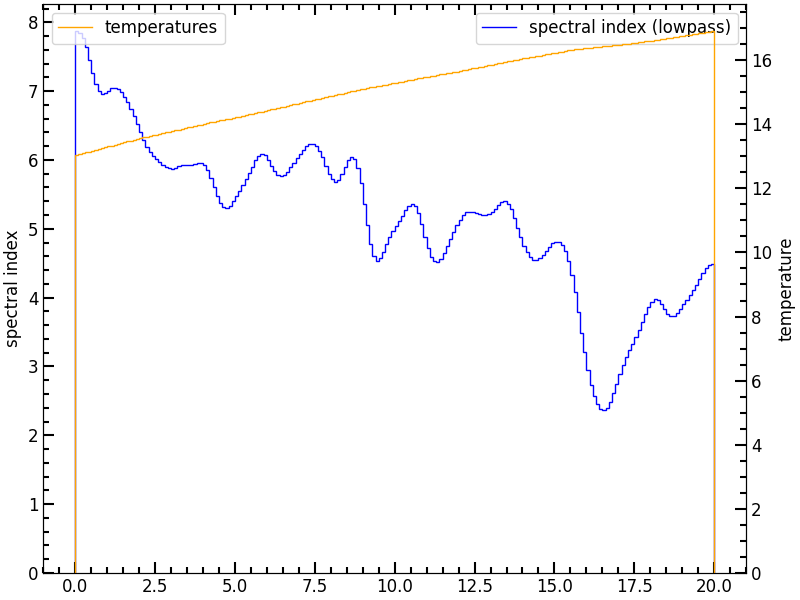

In [24]:
fig, ax = plt.subplots()
ax.stairs(low_idx, time_bins.value, label="spectral index (lowpass)", color="blue")
axx = ax.twinx()
axx.stairs(temps, time_bins.value, label="temperatures", color="orange")

ax.legend()
ax.set(ylabel="spectral index")
axx.set(ylabel="temperature")
axx.legend()
plt.show()

In [25]:
# The nonthermal emission should extend to rather low energies
cutoff_energies = (10 << u.keV) * np.ones_like(time_mids.value)

In [26]:
energy_bins = np.concatenate((np.geomspace(4, 200, num=32), [600])) << u.keV
exposure = total_time
de = np.diff(energy_bins) << u.keV
energy_mids = (energy_bins[:-1] + np.diff(energy_bins) / 2) << u.keV

In [27]:
# Effective area of 10cm2 with 100um of Al
geometric_area = 10 << u.cm**2
response_vector = (
    (u.ct / u.ph) * geometric_area * np.ones(energy_bins.size - 1)
)  # [1.56e-03, 6.77e-03, 2.30e-02, 6.39e-02, 1.51e-01, 3.09e-01, 5.62e-01, 9.26e-01, 1.40e+00, 1.97e+00, 2.62e+00, 3.31e+00, 4.03e+00, 4.73e+00, 5.40e+00, 6.03e+00, 6.60e+00, 7.11e+00, 7.56e+00, 7.94e+00, 8.28e+00, 8.57e+00, 8.81e+00, 9.01e+00, 9.18e+00, 9.33e+00, 9.44e+00, 9.54e+00, 9.62e+00, 9.69e+00, 9.74e+00, 9.79e+00, 9.83e+00, 9.86e+00, 9.88e+00, 9.90e+00, 9.92e+00, 9.93e+00, 9.95e+00, 9.96e+00, 9.96e+00, 9.97e+00, 9.97e+00, 9.98e+00, 9.98e+00, 9.99e+00, 9.99e+00, 9.99e+00, 9.99e+00, 9.99e+00, 9.99e+00, 9.99e+00, 1.00e+01, 1.00e+01, 1.00e+01, 1.00e+01, 1.00e+01, 1.00e+01, 1.00e+01,] << (u.cm**2 * u.ct / u.ph)

In [28]:
thermal_truth = np.zeros((time_mids.size, energy_bins.size - 1)) << u.ct
nonthermal_truth = np.zeros((time_mids.size, energy_bins.size - 1)) << u.ct

for i in range(cutoff_energies.size):
    parameters = {
        "temperature": temps[i],
        "emission_measure": ems[i],
        "cutoff_energy": cutoff_energies[i],
        "spectral_index": low_idx[i] << u.one,
        "electron_flux": (float(low_eflux[i]) << (1e35 * u.electron / u.s)),
    }

    parameters = {k: Parameter(v, True) for (k, v) in parameters.items()}
    args = {
        "parameters": parameters,
        "photon_energy_edges": energy_bins.to_value(u.keV),
    }
    thermal_truth[i] = response_vector * (
        (cm.thermal(args) << (u.ph / u.cm**2 / u.keV / u.s)) * time_bin * de
    )
    # nonthermal_truth[i] = response_vector * ((warm_thick_target(args) << (u.ph / u.keV / u.cm**2 / u.s)) * time_bin * de)
    nonthermal_truth[i] = response_vector * (
        (cm.thick_target(args) << (u.ph / u.keV / u.cm**2 / u.s)) * time_bin * de
    )

thermal_truth[thermal_truth < 0] = 0
nonthermal_truth[nonthermal_truth < 0] = 0

thermal_truth = thermal_truth.astype(int)
nonthermal_truth = nonthermal_truth.astype(int)


def full_spectrogram():
    return thermal_truth + nonthermal_truth

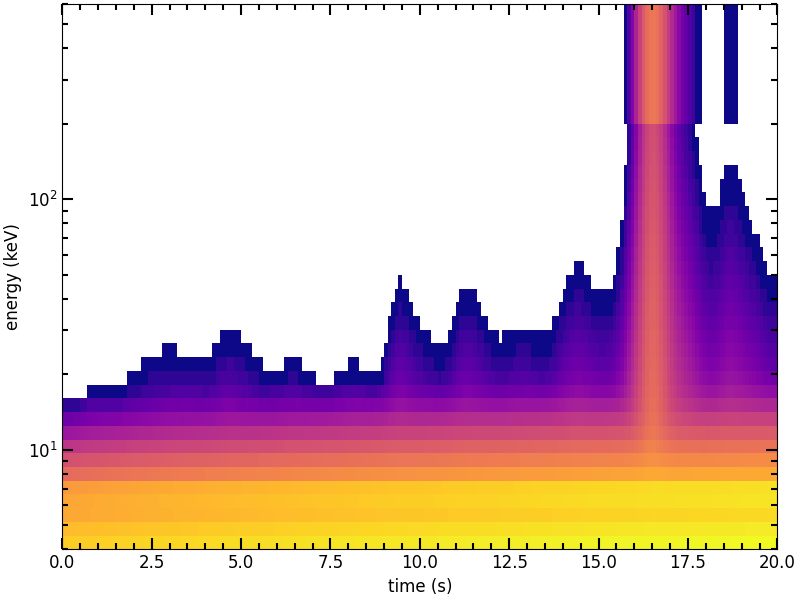

In [29]:
import matplotlib.colors as mcol

unit = u.ct

fig, ax = plt.subplots()
norm = mcol.LogNorm()
cmap = plt.get_cmap("plasma").copy()
ax.pcolormesh(
    time_bins.to_value(u.s),
    energy_bins,
    full_spectrogram().T.to_value(unit).astype(int),
    norm=norm,
    cmap=cmap,
)
ax.set(yscale="log", xlabel="time (s)", ylabel="energy (keV)")
plt.show()

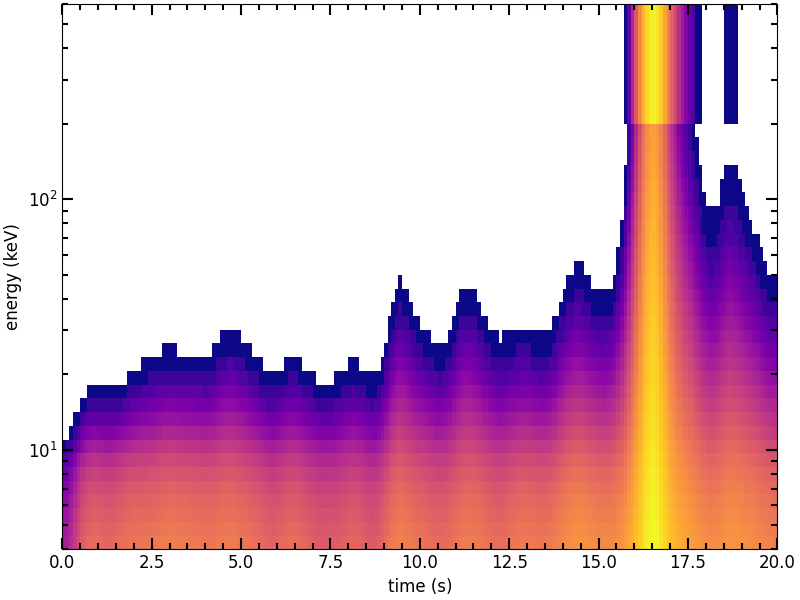

In [30]:
import matplotlib.colors as mcol

unit = u.ct

fig, ax = plt.subplots()
norm = mcol.LogNorm()
cmap = plt.get_cmap("plasma").copy()
ax.pcolormesh(
    time_bins.to_value(u.s),
    energy_bins,
    nonthermal_truth.T.to_value(unit).astype(int),
    norm=norm,
    cmap=cmap,
)
ax.set(yscale="log", xlabel="time (s)", ylabel="energy (keV)")
plt.show()

In [31]:
def closest(a, v):
    return np.argmin(np.abs(a - v))


"""
Let's say we have a Ba133 source on board.
For X-rays that's about 2e5 count/second.
There will be lines at 4 keV, 31 keV, and 81 keV
"""
noise = np.zeros_like(thermal_truth[0].value).astype(float)

baseline_rate = 30 << u.Hz / u.keV
baseline_cts = baseline_rate * time_bin * num_time_bins * de
noise += baseline_cts

line1_rate = 100 << u.Hz / u.keV
line1_cts = line1_rate * time_bin * num_time_bins * de
# noise[closest(energy_mids, 6 << u.keV):closest(energy_mids, 7 << u.keV)] += line1_cts

line2_rate = 50 << u.Hz / u.keV
line2_cts = line2_rate * time_bin * num_time_bins * de
# noise[closest(energy_mids, 29 << u.keV):closest(energy_mids, 32 << u.keV)] += line2_cts

# Louder background at high energy
noise[closest(energy_mids, 120 << u.keV) :] *= 4

# Given the average count rate, we expect a certain amount of noise
rate = noise / num_time_bins
noise_spectrogram = st.poisson.rvs(np.tile(rate, (num_time_bins, 1))) << u.ct
# noise_spectrogram *= 0

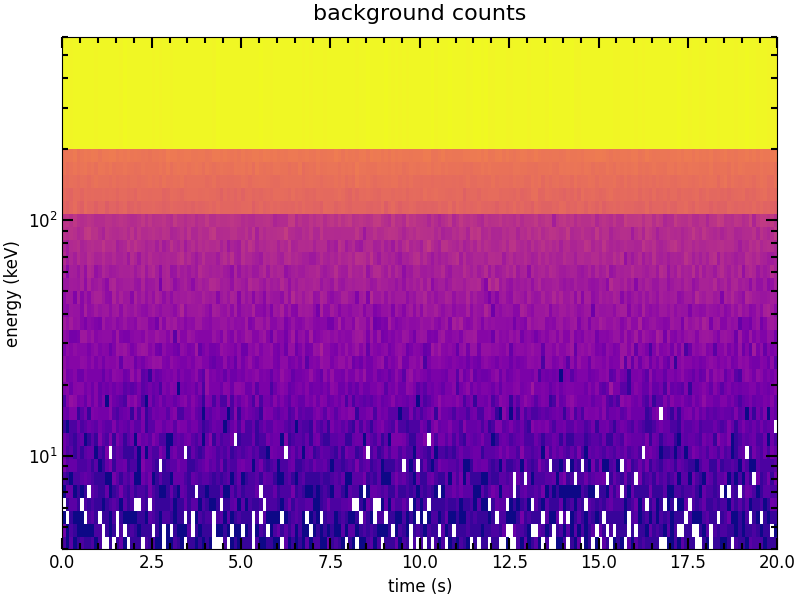

In [32]:
import matplotlib.colors as mcol

unit = u.ct

fig, ax = plt.subplots()
norm = mcol.LogNorm()
cmap = plt.get_cmap("plasma").copy()
ax.pcolormesh(
    time_bins.to_value(u.s),
    energy_bins,
    noise_spectrogram.value.T,
    norm=norm,
    cmap=cmap,
)
ax.set(
    yscale="log", xlabel="time (s)", ylabel="energy (keV)", title="background counts"
)
plt.show()

In [33]:
mean = (thermal_truth + nonthermal_truth + noise_spectrogram).to_value(u.ct).astype(int)
data = st.poisson.rvs(mean) << u.ct
systematic = 0.1
data_err = (
    np.sqrt(data.to_value(u.ct) + (systematic * data.to_value(u.ct)) ** 2) << u.ct
)

data[data < 0] = 0

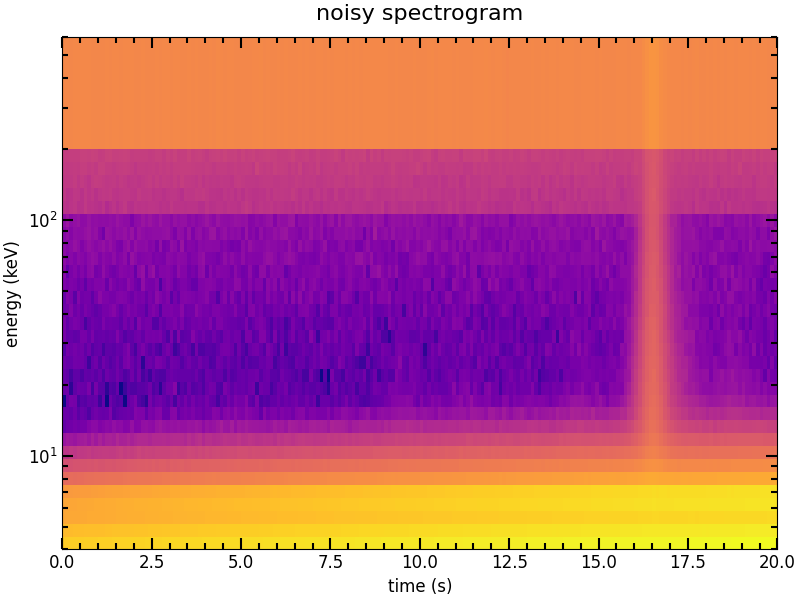

In [34]:
import matplotlib.colors as mcol

unit = u.ct

fig, ax = plt.subplots()
norm = mcol.LogNorm()
cmap = plt.get_cmap("plasma").copy()
ax.pcolormesh(time_bins.to_value(u.s), energy_bins, data.T.value, norm=norm, cmap=cmap)
ax.set(
    yscale="log", xlabel="time (s)", ylabel="energy (keV)", title="noisy spectrogram"
)
plt.show()

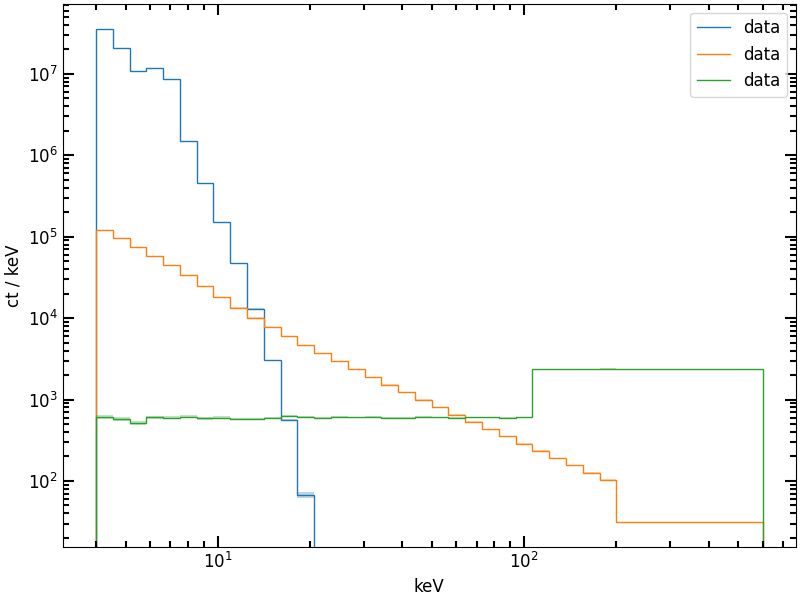

In [35]:
from yaff import plotting

fig, ax = plt.subplots()


def pois(a):
    a = a.to_value(u.ct)
    return np.sqrt(a) << u.ct


with viz.quantity_support():
    plotting.stairs_with_error(
        energy_bins,
        (th := thermal_truth.sum(axis=0)) / de,
        pois(th) / de,
        ax=ax,
        label="data",
    )
    plotting.stairs_with_error(
        energy_bins,
        (nth := nonthermal_truth.sum(axis=0)) / de,
        pois(nth) / de,
        ax=ax,
        label="data",
    )
    plotting.stairs_with_error(
        energy_bins,
        (bkg := noise_spectrogram.sum(axis=0)) / de,
        pois(bkg) / de,
        ax=ax,
        label="data",
    )
    ax.set(xscale="log", yscale="log")
    ax.legend()
plt.show()

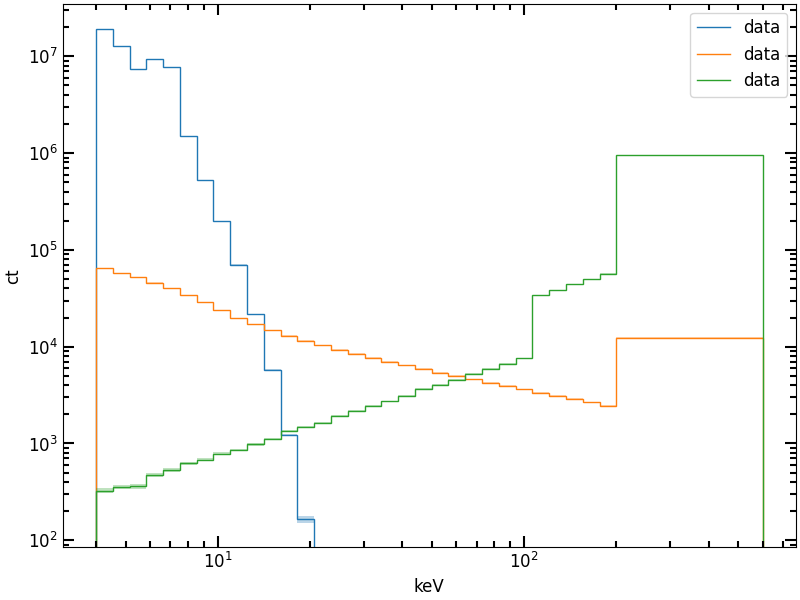

In [36]:
from yaff import plotting

fig, ax = plt.subplots()


def pois(a):
    a = a.to_value(u.ct)
    return np.sqrt(a) << u.ct


with viz.quantity_support():
    plotting.stairs_with_error(
        energy_bins, (th := thermal_truth.sum(axis=0)), pois(th), ax=ax, label="data"
    )
    plotting.stairs_with_error(
        energy_bins,
        (nth := nonthermal_truth.sum(axis=0)),
        pois(nth),
        ax=ax,
        label="data",
    )
    plotting.stairs_with_error(
        energy_bins,
        (bkg := noise_spectrogram.sum(axis=0)),
        pois(bkg),
        ax=ax,
        label="data",
    )
    ax.set(xscale="log", yscale="log")
    ax.legend()
plt.show()

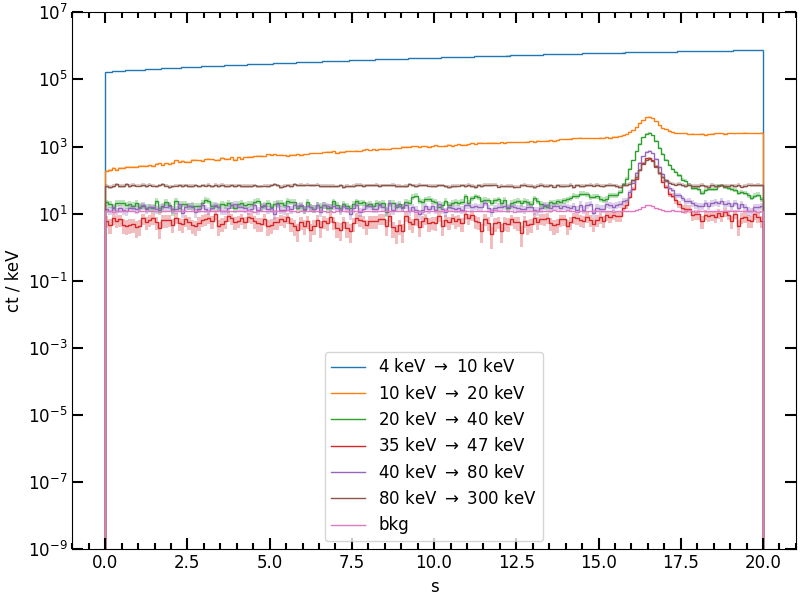

In [37]:
def nearest(a, v):
    return np.argmin(np.abs(a - v))


per_kev = data / de

fig, ax = plt.subplots()
energy_bounds = ((4, 10), (10, 20), (20, 40), (35, 47), (40, 80), (80, 300)) << u.keV
for ea, eb in energy_bounds:
    a, b = nearest(energy_mids, ea), nearest(energy_mids, eb)
    s = per_kev[:, a:b].sum(axis=1)
    plotting.stairs_with_error(
        time_bins,
        s,
        np.sqrt(s.value) << s.unit,
        label=f"{ea:.0f} $\\rightarrow$ {eb:.0f}",
    )
plotting.stairs_with_error(time_bins, per_kev[:, -1], label="bkg")
ax.set(yscale="log", ylim=(1e-9, 1e7))
ax.legend()
plt.show()

In [38]:
from tedec import decomp

In [39]:
dimensionless_data = data.T.astype(float)
dimensionless_errors = data_err.T.astype(float)

thermal_idx = nearest(energy_mids, 5 << u.keV)
nonthermal_idx = nearest(energy_mids, 22 << u.keV)

pack = decomp.DataPacket(
    data=dimensionless_data,
    basis_timeseries=[
        dimensionless_data[thermal_idx - 1 : thermal_idx + 2].sum(axis=0),
        dimensionless_data[nonthermal_idx - 1 : nonthermal_idx + 2].sum(axis=0),
        dimensionless_data[-1],
    ],
    constant_offset=(was_offset := False),
)

# systematic = 0.1
ret = decomp.bootstrap(pack, errors=dimensionless_errors, num_iter=1000)

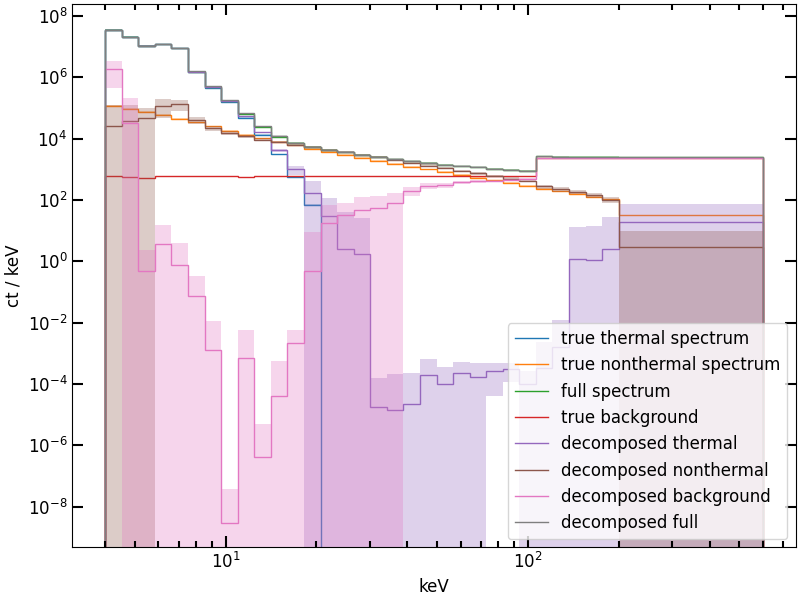

In [40]:
from yaff import plotting
from astropy import visualization as viz

sys = 0.05


def err(a):
    return np.sqrt(a + (a * sys) ** 2)


th_mean = ret[:, 0, :].mean(axis=0) << u.ct
th_std = ret[:, 0, :].std(axis=0) << u.ct
nth_mean = ret[:, 1, :].mean(axis=0) << u.ct
nth_std = ret[:, 1, :].std(axis=0) << u.ct

# scale by # time bins (need to update)
bkg_part = ret[:, 2, :]  # * (num_time_bins - 1)
if was_offset:
    bkg_part *= num_time_bins
# bkg_part = ret[:, 1, :] * 0
bkg_mean = bkg_part.mean(axis=0) * u.ct
bkg_std = bkg_part.std(axis=0) * u.ct

fig, ax = plt.subplots()

with viz.quantity_support():
    plotting.stairs_with_error(
        energy_bins,
        (th := thermal_truth.sum(axis=0)) / de,
        (err(th.value) << u.ct) / de,
        label="true thermal spectrum",
    )
    plotting.stairs_with_error(
        energy_bins,
        (nth := nonthermal_truth.sum(axis=0)) / de,
        (err(nth.value) << u.ct) / de,
        label="true nonthermal spectrum",
    )
    plotting.stairs_with_error(
        energy_bins,
        (dm := dimensionless_data.sum(axis=1) << u.ct) / de,
        (err(dm.value) << u.ct) / de,
        label="full spectrum",
    )
    ax.stairs(noise_spectrogram.sum(axis=0) / de, energy_bins, label="true background")

    num_sigma = 2
    plotting.stairs_with_error(
        energy_bins << u.keV,
        th_mean / de,
        num_sigma * th_std / de,
        ax=ax,
        label="decomposed thermal",
    )
    plotting.stairs_with_error(
        energy_bins << u.keV,
        nth_mean / de,
        num_sigma * nth_std / de,
        ax=ax,
        label="decomposed nonthermal",
    )
    plotting.stairs_with_error(
        energy_bins << u.keV,
        bkg_mean / de,
        num_sigma * bkg_std / de,
        ax=ax,
        label="decomposed background",
    )
    plotting.stairs_with_error(
        energy_bins << u.keV,
        (nth_mean + th_mean + bkg_mean) / de,
        num_sigma * np.sqrt(nth_std**2 + th_std**2 + bkg_std**2) / de,
        ax=ax,
        label="decomposed full",
    )

ax.legend()
ax.set(xscale="log", yscale="log", ylim=(None, None))
plt.show()

In [ ]:
# Thank you, ChatGPT

from scipy.stats import rv_continuous
from scipy.special import erf


class MollifiedUniform(rv_continuous):
    """
    A 'uniform but smoothed at edges' distribution.

    Parameters
    ----------
    a : float
        Lower bound
    b : float
        Upper bound
    sigma : float
        Width of Gaussian mollifier (how smooth the edges are)
    """

    def __init__(self, a, b, sigma):
        super().__init__(a=a, b=b, name="mollified_uniform")
        self.a = a
        self.b = b
        self.sigma = sigma

        # Precompute normalization constant for logpdf
        # Convolution of a top-hat with a Gaussian has closed form normalization:
        Z = 0.5 * (erf((b - a) / (np.sqrt(2) * sigma))) * np.sqrt(2 * np.pi) * sigma
        self._logZ = np.log(Z)

    def _logpdf(self, x):
        x = np.asarray(x)

        # Hard bounds:
        out = np.full_like(x, -np.inf, dtype=float)
        inside = (x >= self.a) & (x <= self.b)
        if not np.any(inside):
            return out

        # Smoothed uniform: log of convolution with Gaussian
        # log [ Φ((x - a)/σ) - Φ((x - b)/σ) ]
        xa = (x[inside] - self.a) / (np.sqrt(2) * self.sigma)
        xb = (x[inside] - self.b) / (np.sqrt(2) * self.sigma)

        val = 0.5 * (erf(xa) - erf(xb))
        # Avoid issues when extremely close to edges
        val = np.maximum(val, 1e-300)

        out[inside] = np.log(val) - self._logZ
        return out

In [ ]:
from yaff import common_likelihoods

# mu = lambda a, b: MollifiedUniform(a, b, 0.01).logpdf
# fitting.simple_bounds = mu


def systematic(s, c, a):
    return np.sqrt(s**2 + ((c * a).value << s.unit) ** 2)


sys = 0.05
nth_data = fitting.DataPacket(
    counts=(nth_as_cts := nth_mean),
    counts_error=systematic(nth_std, nth_as_cts, sys),
    background_counts=(0 * nth_as_cts),
    background_counts_error=(0 * nth_as_cts),
    effective_exposure=total_time,
    count_energy_edges=energy_bins,
    photon_energy_edges=energy_bins,
    response_matrix=np.diag(response_vector),
)

nonthermal_priors = {
    # 'electron_flux': MollifiedUniform(0, 20, 0.01).logpdf,
    # 'spectral_index': MollifiedUniform(0.1, 10, 0.01).logpdf,
    # 'cutoff_energy': MollifiedUniform(0.1, 30, 0.01).logpdf,
    "electron_flux": fitting.simple_bounds(0, 20),
    "spectral_index": fitting.simple_bounds(0.1, 10),
    "cutoff_energy": fitting.simple_bounds(0.1, 30),
}

nonthermal_params = {
    "electron_flux": fitting.Parameter(2 << (1e35 * u.electron / u.s), False),
    "spectral_index": fitting.Parameter(5 << u.one, False),
    "cutoff_energy": fitting.Parameter(20 << u.keV, True),
}

rng = np.random.default_rng()
params = {
    k: fitting.Parameter(v.as_quantity() * rng.uniform(0.9, 1.1), frozen=False)
    for (k, v) in nonthermal_params.items()
}
params["cutoff_energy"].value = 10
# params['cutoff_energy'].frozen = False

fit_range = (energy_mids.value > 10) & (energy_mids.value < 100)
likelihood = common_likelihoods.chi_squared_factory(fit_range)

fr = fitting.BayesFitter(
    data=nth_data,
    model_function=cm.thick_target,
    parameters=params,
    log_priors=nonthermal_priors,
    log_likelihood=likelihood,
)

In [ ]:
fr = fitting.levenberg_minimize(fr, restriction=fit_range)
fr.parameters

In [ ]:
fr.run_emcee(emcee_constructor_kw={"nwalkers": 20}, emcee_run_kw={"nsteps": 1000})

In [ ]:
from yaff import plotting as yap

yap.plot_parameter_chains(
    fr, names=fr.free_param_names, params=list(fr.free_parameters)
)
plt.show()

In [ ]:
samples = fr.generate_model_samples(100)
fig = plt.figure()
yap.plot_data_model(fr, model_samples=samples, fig=fig)
plt.show()

In [ ]:
import corner

burnin = 50 * fr.emcee_sampler.nwalkers
corner_chain = fr.emcee_sampler.flatchain[burnin:]
param_names = fr.free_param_names

fig = plt.figure(figsize=(10, 8), layout="tight")
corner.corner(
    corner_chain,
    fig=fig,
    bins=20,
    labels=param_names,
    quantiles=(0.05, 0.5, 0.95),
    show_titles=True,
    truths=(low_eflux.mean(), low_idx.mean(), 3),
    # plot_contours=False,
    # range=(
    #     (14, 20),
    #     (3.9, 4.4),
    #     (24, 30)
    # ),
    truth_color="red",
)
fig.savefig("decomp nonthermal.png", dpi=300)
plt.show()

In [ ]:
low_eflux.mean(), low_idx.mean(), low_eflux.min(), low_eflux.max()
low_idx.min(), low_idx.max()

### Fit thermal decomposed data

In [ ]:
from yaff import fitting
from yaff import common_likelihoods

th_data = fitting.DataPacket(
    counts=(th_as_cts := th_mean),
    counts_error=systematic(th_std, th_as_cts, sys) << u.ct,
    background_counts=(0 * th_as_cts),
    background_counts_error=(0 * th_as_cts),
    effective_exposure=total_time,
    count_energy_edges=energy_bins,
    photon_energy_edges=energy_bins,
    response_matrix=np.diag(response_vector),
)

thermal_priors = {
    "temperature": fitting.simple_bounds(10, 40),
    "emission_measure": fitting.simple_bounds(1e-4, 1e4),
}

thermal_params = {
    "temperature": fitting.Parameter(20 << u.MK, False),
    "emission_measure": fitting.Parameter(1 << (1e47 * u.cm**-3), False),
}

rng = np.random.default_rng()
params = {
    k: fitting.Parameter(v.as_quantity() * rng.uniform(0.9, 1.1), frozen=False)
    for (k, v) in thermal_params.items()
}

likelihood = common_likelihoods.chi_squared_factory(
    restriction=(restriction := (energy_mids.value < 20))
)

fr = fitting.BayesFitter(
    data=th_data,
    model_function=cm.thermal,
    parameters=params,
    log_priors=thermal_priors,
    log_likelihood=likelihood,
)

In [ ]:
fitting.levenberg_minimize(fr, restriction=restriction)

In [ ]:
fr.parameters

In [ ]:
fr.run_emcee(emcee_constructor_kw={"nwalkers": 20}, emcee_run_kw={"nsteps": 1000})

In [ ]:
from yaff import plotting as yap

yap.plot_parameter_chains(
    fr, names=fr.free_param_names, params=list(fr.free_parameters)
)
plt.show()

In [ ]:
import corner

burnin = 100 * fr.emcee_sampler.nwalkers
corner_chain = fr.emcee_sampler.flatchain[burnin:]
param_names = fr.free_param_names

fig = plt.figure(figsize=(10, 8), layout="tight")
corner.corner(
    corner_chain,
    fig=fig,
    bins=20,
    labels=param_names,
    quantiles=(0.05, 0.5, 0.95),
    show_titles=True,
    truths=(
        temps.mean().to_value(u.MK),
        em_start.value,
    ),
    truth_color="red",
)
plt.savefig("decomp thermal.png", dpi=300)
plt.show()

In [ ]:
temps.min(), temps.max()

In [ ]:
samples = fr.generate_model_samples(num=100)
fig = plt.figure()
yap.plot_data_model(fr, model_samples=samples, fig=fig)
plt.show()

## Do a traditional two-model fit

In [ ]:
dp = fitting.DataPacket(
    counts=(cts := data.sum(axis=0).value) << u.ct,
    counts_error=np.sqrt(cts + (sys * cts) ** 2) << u.ct,
    background_counts=(bg := noise_spectrogram.sum(axis=0).value) << u.ct,
    background_counts_error=np.sqrt(bg + (sys * bg) ** 2) << u.ct,
    effective_exposure=total_time,
    count_energy_edges=energy_bins,
    photon_energy_edges=energy_bins,
    response_matrix=np.diag(response_vector),
)

In [ ]:
priors = thermal_priors | nonthermal_priors
params = {
    k: fitting.Parameter(v.as_quantity() * rng.uniform(0.9, 1.1), frozen=False)
    for (k, v) in (thermal_params | nonthermal_params).items()
}


def model(args):
    return cm.thermal(args) + cm.thick_target(args)


likelihood = common_likelihoods.chi_squared_factory(
    restriction := energy_mids.value < 70
)

fr = fitting.BayesFitter(
    data=dp,
    model_function=model,
    parameters=params,
    log_priors=priors,
    log_likelihood=likelihood,
)

In [ ]:
fr.parameters

In [ ]:
fitting.levenberg_minimize(fr, restriction)

In [ ]:
fr.parameters

In [ ]:
fr.run_emcee(emcee_constructor_kw={"nwalkers": 20}, emcee_run_kw={"nsteps": 1000})

In [ ]:
from yaff import plotting as yap

yap.plot_parameter_chains(
    fr, names=fr.free_param_names, params=list(fr.free_parameters)
)
plt.show()

In [ ]:
fr.parameters

In [ ]:
import corner

burnin = 50 * fr.emcee_sampler.nwalkers
corner_chain = fr.emcee_sampler.flatchain[burnin:]
param_names = fr.free_param_names

fig = plt.figure(figsize=(20, 20), layout="tight")
corner.corner(
    corner_chain,
    fig=fig,
    bins=20,
    labels=param_names,
    quantiles=(0.05, 0.5, 0.95),
    show_titles=True,
    truths=(
        temps.mean().to_value(u.MK),
        em_start.value,
        low_eflux.mean(),
        low_idx.mean(),
        20,
    ),
    truth_color="red",
)

plt.savefig("traditional.png", dpi=300)
plt.show()

In [ ]:
samples = fr.generate_model_samples(num=100)
fig = plt.figure()
yap.plot_data_model(fr, model_samples=samples, fig=fig)
plt.show()

In [ ]:
low_idx.mean(), low_idx.std()